### Brent Biseda
### W207
### Project 3
### Tuesday @ 4 PM Pacific Time

# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture #Changed import name
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print (train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

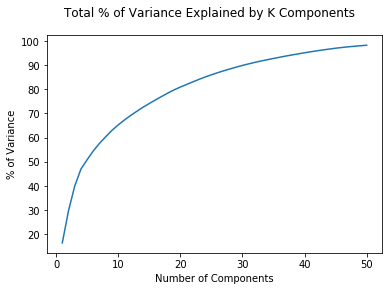

In [4]:
def P1(n=50):
    """Run Principal Component Analysis on data.  We will graph fraction of variance 
    in training data explainable by first k principal components for k in [1:50]"""
    
    pca = PCA() #Scikit Learn PCA
    
    model = pca.fit_transform(train_data) #Train PCA

    explainedVariancePercent = np.cumsum(pca.explained_variance_ratio_)*100 #Report in %

    plt.plot([component+1 for component in range(n)], explainedVariancePercent[:n]) #Plot Variance%
    plt.suptitle('Total % of Variance Explained by K Components')
    plt.ylabel('% of Variance')
    plt.xlabel('Number of Components')

    pass

P1(n=50)

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

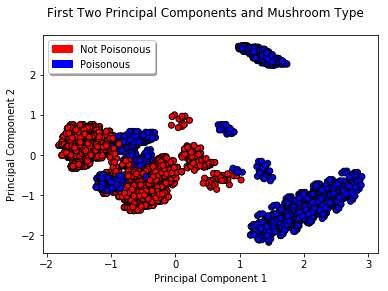

In [5]:
import matplotlib.patches as mpatches

def P2():
    """Project the data to 2 principal components then plot 
    poisonous cases in blue and non-poisonous cases in red"""
    
    #from matplotlib import colors
    
    pca = PCA(n_components=2) #Create PCA - 2 Components only
    model = pca.fit_transform(train_data) #Train the PCA Model
    
    colorsDict = {0:'red', 1:'blue'}
    colors = [colorsDict[i] for i in train_labels]

    plt.scatter(model[:,0], model[:,1], c=colors, edgecolors='k')
    
    plt.ylabel('Principal Component 2')
    plt.xlabel('Principal Component 1')
    plt.suptitle('First Two Principal Components and Mushroom Type')
    
    red_patch = mpatches.Patch(color='red', label='Not Poisonous')
    blue_patch = mpatches.Patch(color='blue', label='Poisonous')
    plt.legend(loc='upper left', handles=[red_patch, blue_patch], shadow=True, ncol=1)

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

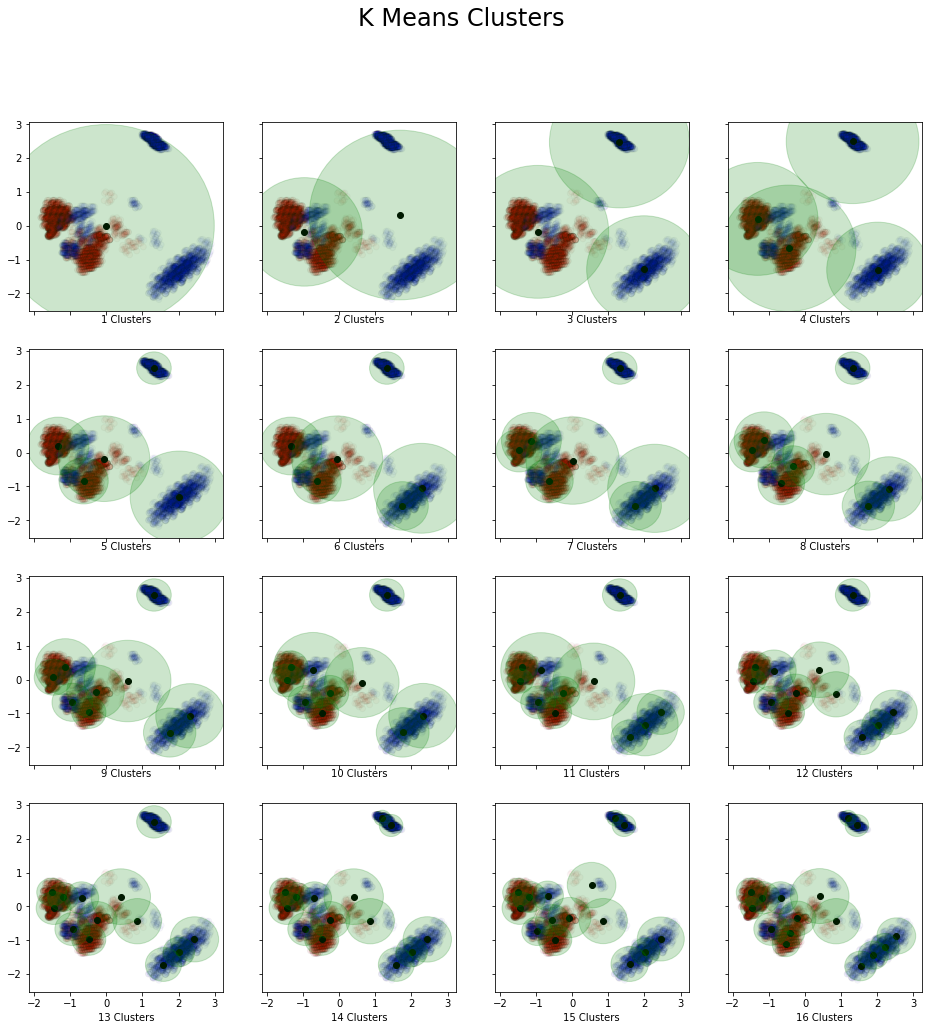

In [6]:
import math

def P3():
    """Perform K Means Clusering for 1:16 clusters over the 2 dimensions from PCA.
    Mark each centroid cluster and plot a circle through most distant cluster point.
    """
    k = 16 #Look at 16 Clusters
    
    pca = PCA(n_components=2) #Create 2 component PCA
    reduced_data = pca.fit_transform(train_data) #Fit Data
    
    fig, axes = plt.subplots(math.ceil(math.sqrt(k)), math.ceil(math.sqrt(k)),
                            figsize = (16, 16), sharex=True, sharey=True)
    
    plt.suptitle('K Means Clusters', fontsize=24)
    
    for i, ax in enumerate(axes.reshape(-1)):
        colorsDict = {0:'red', 1:'blue'}
        colors = [colorsDict[i] for i in train_labels]

        ax.scatter(x = reduced_data[:,0], y = reduced_data[:,1], c=colors, edgecolors='k', alpha=0.03)
        kmeans = KMeans(n_clusters=(i+1))
        kmeans.fit(reduced_data)
        
        for clusterNum, cluster in enumerate(kmeans.cluster_centers_): # Iterate through each cluster
            x, y = cluster # Get centroid points
            ax.scatter(x, y , c='k', alpha=1.0) # Plot the Centroids
            
            # Calculate radius of circle
            clusterPoints = reduced_data[(kmeans.labels_==clusterNum)]
            clusterDistance = [math.sqrt((xPoint - x)**2 + (yPoint-y)**2) for xPoint, yPoint in clusterPoints]
            clusterRadius = max(clusterDistance)
            clusterCircle = plt.Circle((x, y), clusterRadius, color='g', alpha=0.2)
            ax.add_artist(clusterCircle)

        ax.set_xlabel(str(str(i+1)+" Clusters"))
    
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: val

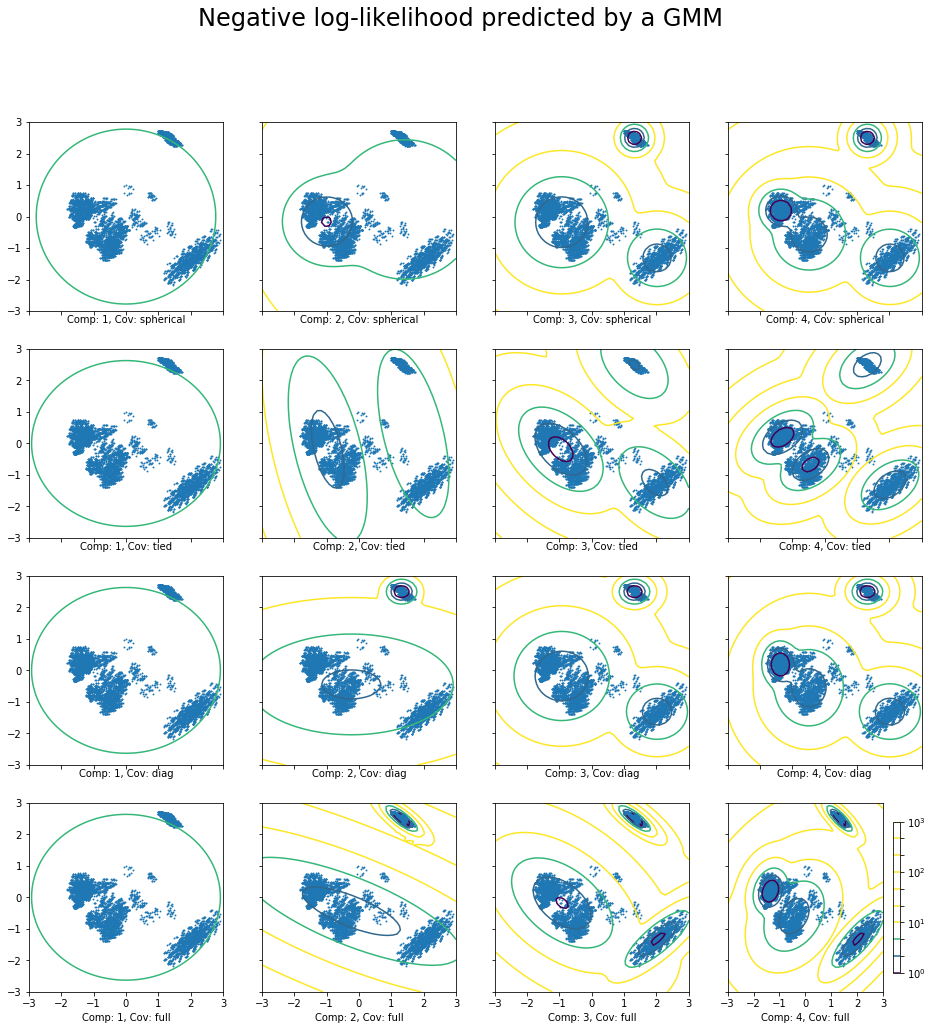

In [7]:
def P4():
    """
    Fit a Gaussian Mixture Model for the PCA projected data.
    Plot estimated Density Contours.
    Vary Mixture components from 1-4 and Covariance Matrix type: ('spherical', 'diag', 'tied', 'full')
    """
    pca = PCA(n_components=2) #Create 2 component PCA
    reduced_data = pca.fit_transform(train_data) #Fit Data
    
    mixtureComponents = [1, 2, 3, 4]
    covarianceTypes = ['spherical', 'tied', 'diag', 'full']
    fig, axes = plt.subplots(4, 4, figsize = (16, 16), sharex=True, sharey=True)
    
    plt.suptitle('Negative log-likelihood predicted by a GMM', fontsize=24)
    
    for i, covariance in enumerate(covarianceTypes):
        for j, mixture in enumerate(mixtureComponents):
            model = GaussianMixture(n_components = mixture, covariance_type = covariance)
            model.fit(reduced_data)
            
            # Taken from: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
            # display predicted scores by the model as a contour plot
            x = np.linspace(-3., 3.) #Restrict to range from previous question
            y = np.linspace(-3., 3.) #Restrict to range from previous question
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -model.score_samples(XX)
            Z = Z.reshape(X.shape)
            CS = axes[i][j].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0), 
                                    levels=np.logspace(0, 3, 10))
            
            axes[i][j].scatter(reduced_data[:, 0], reduced_data[:, 1], .8)
            axes[i][j].set_xlabel("Comp: " + str(mixture) + ", Cov: "+ covariance)
    CB = fig.colorbar(CS, shrink=0.8, extend='both') # Set Color Bars

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
    """
    Fit 2 4-component full covariance GMMs.  One for positive Examples & One for Negative Examples in 
    reduced PCA space.  Predict test examples and calculate model accuracy"""
    pca = PCA(n_components=2) #Create 2 component PCA
    reduced_data = pca.fit_transform(train_data) #Fit Data
    
    model0 = GaussianMixture(n_components = 4, covariance_type = 'full')
    model0.fit(reduced_data[train_labels==0]) #Non-poisonous Model
    
    model1 = GaussianMixture(n_components = 4, covariance_type = 'full')
    model1.fit(reduced_data[train_labels==1]) #Poisonous Model
        
    reduced_test = pca.transform(test_data) #Transform Test Data into 2 dimensions
    
    preds = []
    
    for example in reduced_test: #Iterate through each test example and calculate probabilities
        nonPoisonousProb = (np.exp(model0.score(example.reshape(1,-1))))
        PoisonousProb = (np.exp(model1.score(example.reshape(1,-1))))
        
        if nonPoisonousProb >= PoisonousProb:
            preds += [0]
        else:
            preds += [1]
            
    correctLabels = np.sum(preds==test_labels)
    totalLabels = test_labels.shape[0]
    accuracy = correctLabels / totalLabels
    
    print('The accuracy is {:.3}%'.format(accuracy*100))
    
P5()

The accuracy is 95.0%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
def GetAccuracy(reduced_test, model0, model1):
    preds = []
    for example in reduced_test: #Iterate through each test example and calculate probabilities
        nonPoisonousProb = (np.exp(model0.score(example.reshape(1,-1))))
        PoisonousProb = (np.exp(model1.score(example.reshape(1,-1))))
        
        if nonPoisonousProb >= PoisonousProb:
            preds += [0]
        else:
            preds += [1]
            
    correctLabels = np.sum(preds==test_labels)
    totalLabels = test_labels.shape[0]
    accuracy = correctLabels / totalLabels
    
    return accuracy

def P6():
    """
    Iterate through various component models, covariance types, 
    """
    mixtureComponents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    covarianceTypes = ['spherical', 'tied', 'diag', 'full']
    pcaComponents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    bestAccuracy = 0.0
    bestCovariance = ""
    bestPCAComponent = 0
    bestParameters = 0
    bestMixture = 0
    
    # Iterate through our search region
    for mixture in mixtureComponents:
        for covariance in covarianceTypes:
            for component in pcaComponents:
                
                pca = PCA(n_components=component) #Create 2 component PCA
                reduced_data = pca.fit_transform(train_data) #Fit Data

                model0 = GaussianMixture(n_components = mixture, covariance_type = covariance)
                model0.fit(reduced_data[train_labels==0]) #Non-poisonous Model

                model1 = GaussianMixture(n_components = mixture, covariance_type = covariance)
                model1.fit(reduced_data[train_labels==1]) #Poisonous Model

                reduced_test = pca.transform(test_data) #Transform Test Data into 2 dimensions
                
                # Calculate the Number of Parameters
                cov, means = model0.covariances_, model0.means_
                covParameters = len(cov.flatten())
                meanParameters = len(means.flatten())
                
                parameters = 2 * mixture * (meanParameters + covParameters)

                accuracy = GetAccuracy(reduced_test, model0, model1)
                
                if accuracy > bestAccuracy and parameters <= 50: # Only want 50 parameters or less
                    bestAccuracy = accuracy
                    bestCovariance = covariance
                    bestPCAComponent = component
                    bestParameters = parameters
                    bestMixture = mixture
                    
    print("Best Accuracy: {:.3}, Best Covariance: {}, Best PCA Choice: {}, Best Mixture Choice: {}".format(bestAccuracy*100, 
                                                                                  bestCovariance, bestPCAComponent, bestMixture))
    print("Total Parameters: {}".format(bestParameters))

P6()

Best Accuracy: 93.2, Best Covariance: full, Best PCA Choice: 2, Best Mixture Choice: 2
Total Parameters: 48
